In [27]:
"""Visualize embeddings produced"""
import numpy as np
import tensorflow as tf 
import h5py
import matplotlib.pyplot as plt
import os

from skimage import measure

import utils

%load_ext autoreload
%autoreload 2

os.environ['CUDA_VISIBLE_DEVICES'] = ''

ROOT = '/usr/people/kluther/Projects/metric_segmentation/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
%%javascript
require(
        ["notebook/js/outputarea"],
        function (oa) {
            oa.OutputArea.auto_scroll_threshold = -1;
            console.log("Setting auto_scroll_threshold to -1");
        });

<IPython.core.display.Javascript object>

In [34]:
"""Load data"""
em_imgs  = h5py.File(os.path.join(ROOT, 'data', 'image.h5'), 'r')['main']
seg_imgs = h5py.File(os.path.join(ROOT, 'data', 'human_labels_split.h5'), 'r')['main']
#em_imgs  = h5py.File(os.path.join(ROOT, 'data', 'voronoi_boundary.h5'), 'r')['main']
seg_imgs = h5py.File(os.path.join(ROOT, 'data', 'voronoi_segmentation.h5'), 'r')['main']

"""
em_imgs_train = em_imgs[:192]
seg_imgs_train = seg_imgs[:192]
em_imgs_dev = em_imgs[192:]
seg_imgs_dev = seg_imgs[192:]
"""
em_imgs_train = em_imgs[:16]
seg_imgs_train = seg_imgs[:16]
em_imgs_dev = em_imgs[16:]
seg_imgs_dev = seg_imgs[16:]

In [35]:
"""Load model"""
N = 20000 #Iteration number
EXP_NAME = 'j_loss_boundary_mask_on_split_objects'
MODEL_NAME = os.path.join(ROOT, 'experiments', EXP_NAME, 'models', 'model{}.ckpt'.format(N))

tf.reset_default_graph()
sess = tf.Session()
inputs, outputs = utils.load_model(MODEL_NAME, sess)

INFO:tensorflow:Restoring parameters from /usr/people/kluther/Projects/metric_segmentation/experiments/j_loss_boundary_mask_on_split_objects/models/model20000.ckpt


## Stitch Images ## 

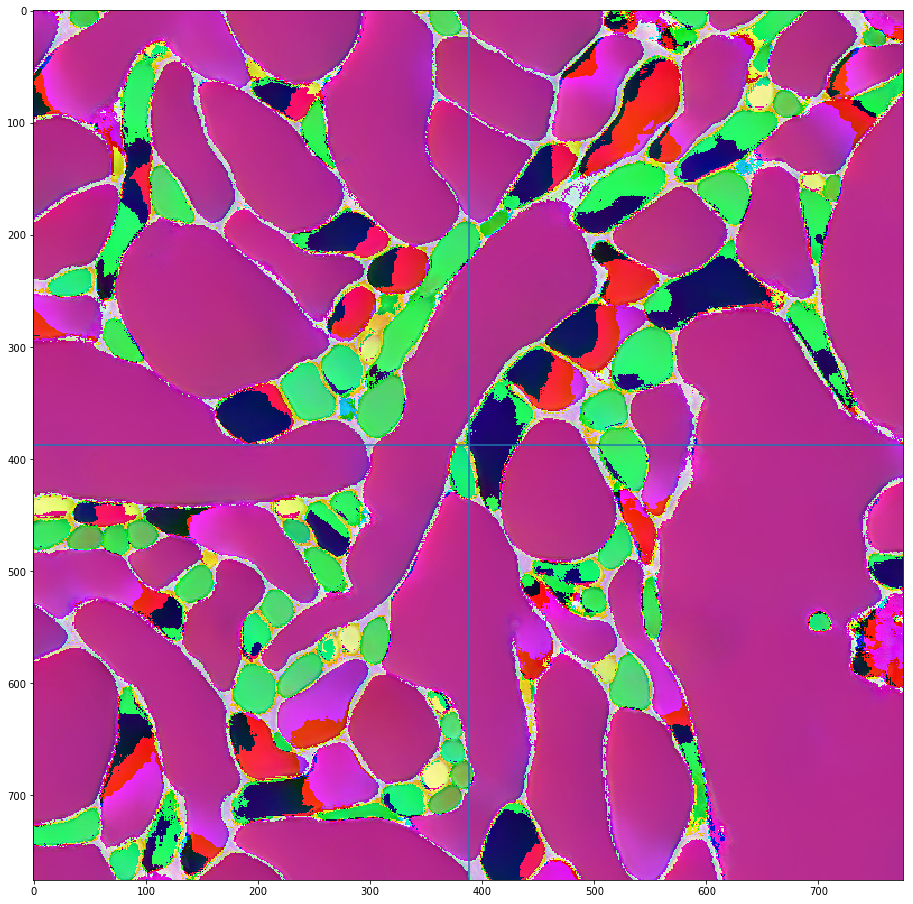

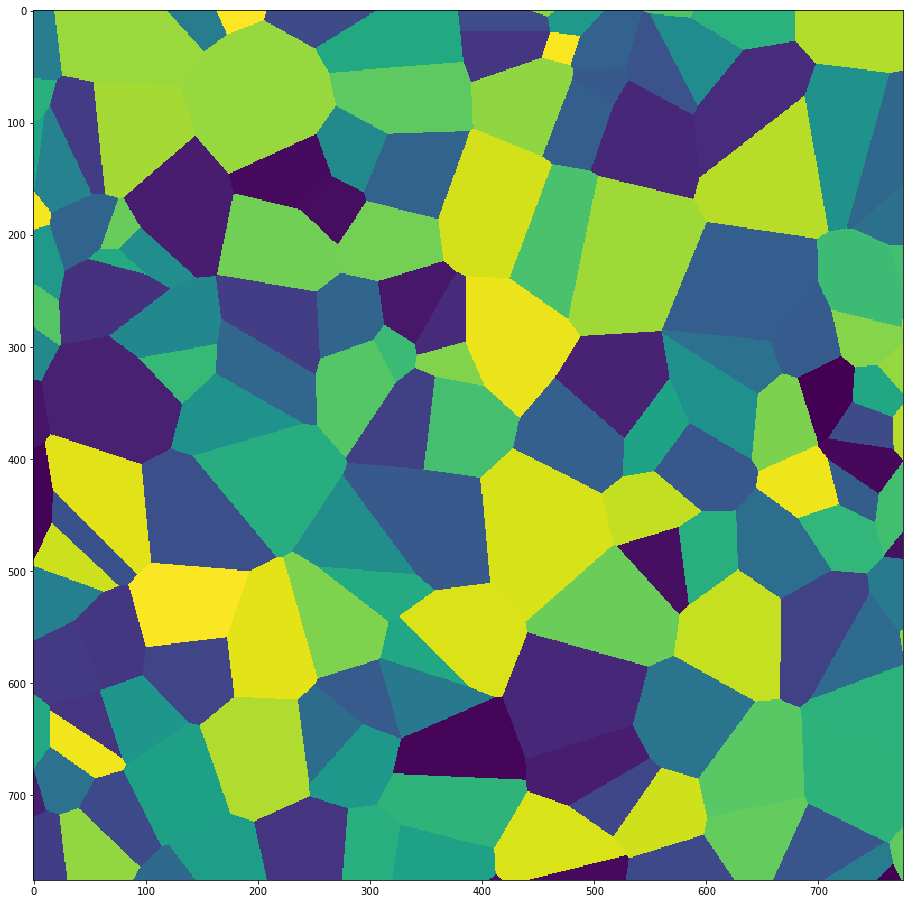

In [36]:
# Get 4 shifted images
em = em_imgs_dev[0]
seg = seg_imgs_dev[0]

e11 = em[0:572, 0:572]
e12 = em[388:960, 0:572]
e21 = em[0:572, 388:960]
e22 = em[388:960, 388:960]

s11 = seg[0:572, 0:572][92:572-92,92:572-92]
s12 = seg[388:960, 0:572][92:572-92,92:572-92]
s21 = seg[0:572, 388:960][92:572-92,92:572-92]
s22 = seg[388:960, 388:960][92:572-92,92:572-92]

# Compute vectors
v11 = utils.generate_vector_labels(inputs, outputs, e11, sess)
v12 = utils.generate_vector_labels(inputs, outputs, e12, sess)
v21 = utils.generate_vector_labels(inputs, outputs, e21, sess)
v22 = utils.generate_vector_labels(inputs, outputs, e22, sess)

# Piece together 
v = np.zeros((388*2,388*2,3))
v[:388,:388] = v11[:,:,:3]
v[388:,:388] = v12[:,:,:3]
v[:388,388:] = v21[:,:,:3]
v[388:,388:] = v22[:,:,:3]

s = np.zeros((388*2,388*2))
s[:388,:388] = s11
s[388:,:388] = s12
s[:388,388:] = s21
s[388:,388:] = s22

# Show images 
plt.figure(figsize=(16,16))
plt.imshow(v)
plt.axvline(x=388,ls='-')
plt.axhline(y=388,ls='-')
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(s)
plt.show()

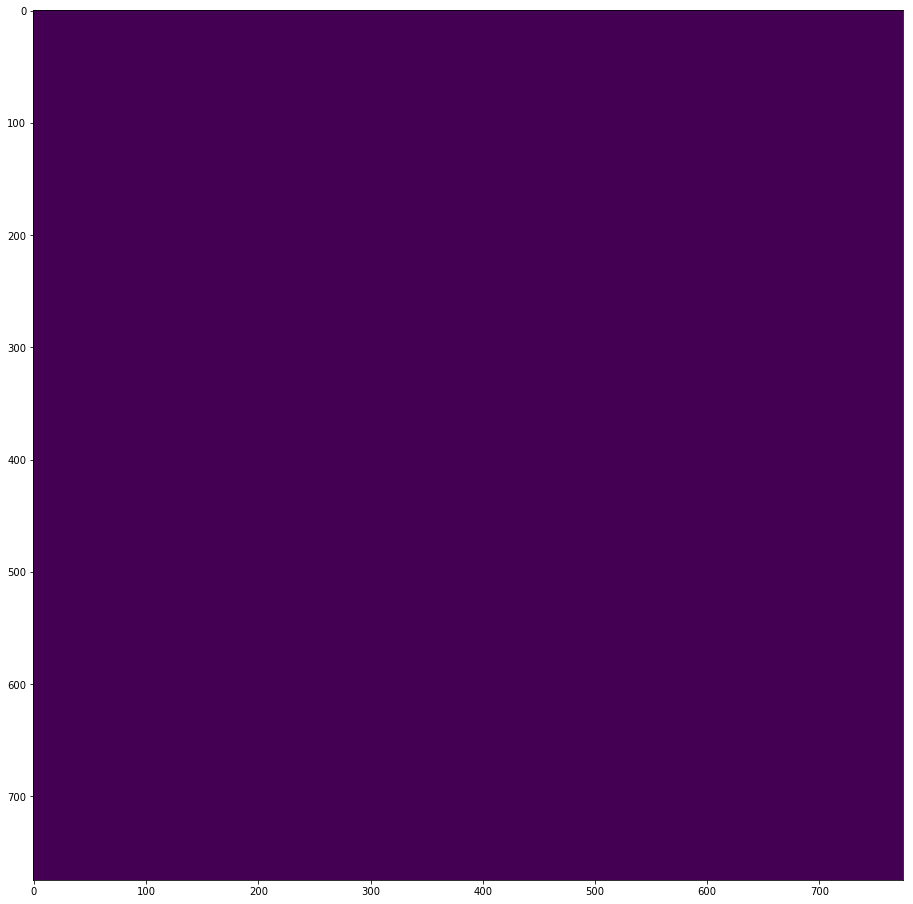

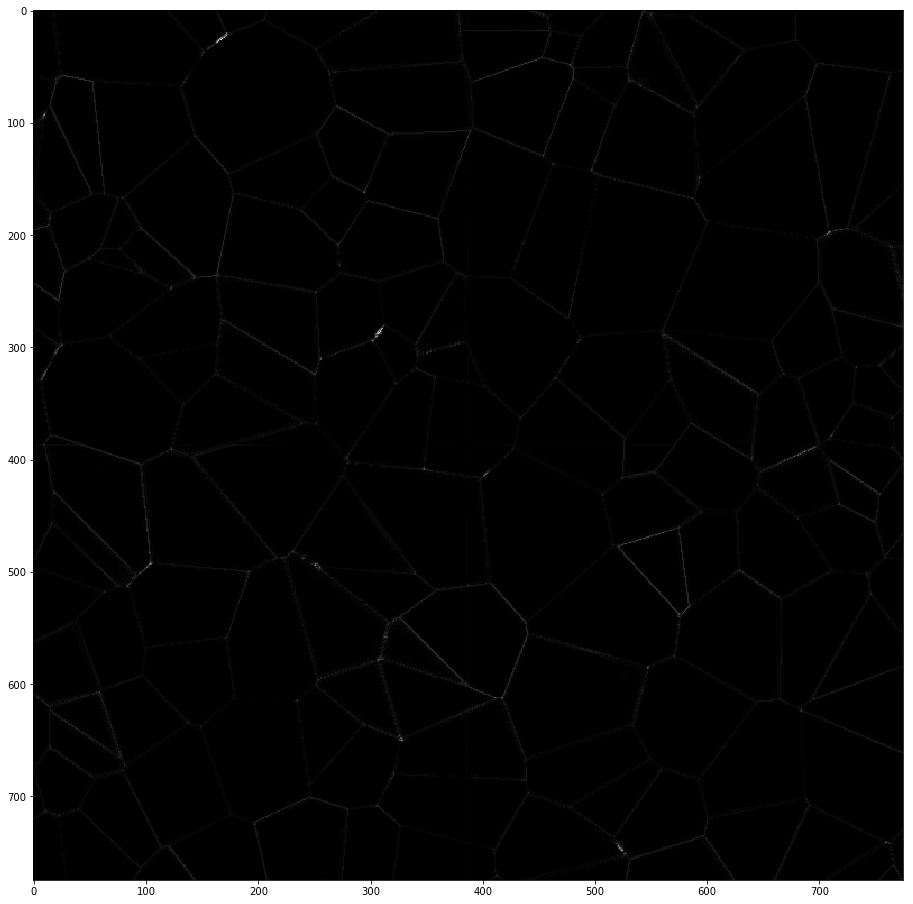

In [19]:
"""Create images to visualize vector labels""" 
# Boundary map
def gradient_norm(vec_field):
  """Returns norm of gradient at each point in vec_field"""
  gx = vec_field[1:,:-1]-vec_field[:-1,:-1]
  gy = vec_field[:-1,1:]-vec_field[:-1,:-1]

  return np.sqrt(np.linalg.norm(gx,axis=-1)**2+np.linalg.norm(gy,axis=-1)**2)

vec_grad = gradient_norm(v)

# Fill in boundary map
thresh = 0.1
labels = measure.label(vec_grad>thresh, background=1)

# Show labels
plt.figure(figsize=(16,16))
plt.imshow(labels); plt.show()
plt.figure(figsize=(16,16))
plt.imshow(vec_grad, cmap='gray'); plt.show()